In [16]:
import numpy as np
import torch
from torch import nn
from torchsde import BrownianInterval, sdeint

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# numbers of cells, freedom, and noise source
batch_size, state_size, brownian_size = 25, 6, 2

# duration of simulation
t_max = 500

# interval of evaluation
t_eval = 1

# method to solve SDE
methodSDE = 'euler'
isIto = True

# time step to simulate
stepSDE = 2e-3

# delay (steps with t_eval interval) for autocorrelation calculation
delaystep = np.arange(50)

# bins for v histogram calculation
vbinwidth = 0.1
vmin = 0
vmax = 5
vbins = torch.tensor(np.arange(vmin, vmax+vbinwidth, vbinwidth), dtype=torch.float, device=device)

# list of steps at which output is collected
ts = torch.arange(0, t_max+t_eval, t_eval, device=device)
Nts = ts.size()[0]


In [17]:
print(vbins)

tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000, 1.0000, 1.1000, 1.2000, 1.3000, 1.4000, 1.5000, 1.6000, 1.7000,
        1.8000, 1.9000, 2.0000, 2.1000, 2.2000, 2.3000, 2.4000, 2.5000, 2.6000,
        2.7000, 2.8000, 2.9000, 3.0000, 3.1000, 3.2000, 3.3000, 3.4000, 3.5000,
        3.6000, 3.7000, 3.8000, 3.9000, 4.0000, 4.1000, 4.2000, 4.3000, 4.4000,
        4.5000, 4.6000, 4.7000, 4.8000, 4.9000, 5.0000], device='cuda:0')


In [18]:
import os

dirName = "/home/uwamichi/miura_kamiya/"

csvdir = dirName + "graph_frameOut_yflip0.142/"

def loadcsv(prefix, surfix):
    return np.loadtxt(csvdir+prefix+surfix, delimiter=',', skiprows=1)

csv_prefix = 'L2_skip{}_'.format(str(t_eval))
csv_surfix = '.csv'

savedir = dirName + 'torchSDE_Adam/'
os.makedirs(savedir, exist_ok=True)

In [19]:
class betasigma(nn.Module):
    def __init__(self, params):
        super(betasigma, self).__init__()

        self.layer1 = nn.Linear(1,1,bias=True, device=device)
       # self.layer2 = nn.Linear(1,1,bias=False)
        self.layer3 = nn.Linear(1,1,bias=False, device=device)

        nn.init.constant_(self.layer1.bias, params[0])
        nn.init.constant_(self.layer1.weight, params[1])
        nn.init.constant_(self.layer3.weight, params[2])

    def forward(self, x):
        # x has shape [N, 1]
        x01 = self.layer1(x)
        x2 = self.layer3(torch.square(x))
        return x01 + x2


class SDE(nn.Module):
    noise_type = 'general'
    sde_type = 'ito' if isIto else 'stratonovich'

    def __init__(self, alpha, beta, gamma, sigma):
        super().__init__()
        self.alpha = nn.Parameter(torch.tensor([[alpha]], requires_grad=True, device=device))
        self.gamma = nn.Parameter(torch.tensor([[gamma]], requires_grad=True, device=device))
        self.beta = betasigma(beta)
        self.sigma = betasigma(sigma)

        self.alpha.register_hook(lambda grad: print('alpha grad', grad))
        self.gamma.register_hook(lambda grad: print('gamma grad', grad))
        self.beta.layer1.bias.register_hook(lambda grad: print('beta0 grad', grad))
        self.beta.layer1.weight.register_hook(lambda grad: print('beta1 grad', grad))
        self.beta.layer3.weight.register_hook(lambda grad: print('beta2 grad', grad))
        self.sigma.layer1.bias.register_hook(lambda grad: print('sigma0 grad', grad))
        self.sigma.layer1.weight.register_hook(lambda grad: print('sigma1 grad', grad))
        self.sigma.layer3.weight.register_hook(lambda grad: print('sigma2 grad', grad))

        
    # Drift
    def f(self, t, y):
        vsmall = y[:, 2:4]
        vlarge = y[:, 4:]

        v_abs = torch.norm(vsmall, dim=1, keepdim=True)
        
        betas = self.beta(v_abs)
        dvsmall = -betas*vsmall + self.alpha * vlarge

        dvlarge = self.alpha * vsmall - self.gamma * vlarge

        return torch.cat((vsmall, dvsmall, dvlarge), 1)  # shape (batch_size, state_size)

    # Diffusion
    def g(self, t, y):
        v_abs_ = torch.unsqueeze(torch.norm(y[:, 2:4], dim=1, keepdim=True), 2)
        sigmas_v = self.sigma(v_abs_)
        sigmas_vx = torch.cat((sigmas_v, torch.zeros_like(sigmas_v)), 2)
        sigmas_vy = torch.cat((torch.zeros_like(sigmas_v), sigmas_v), 2)
        
        sigmas_v2 = torch.cat((sigmas_vx, sigmas_vy), 1)
        sigmas_xy = torch.zeros_like(sigmas_v2)
        sigmas_vlarge = torch.zeros_like(sigmas_v2)

        return torch.cat((sigmas_xy, sigmas_v2, sigmas_vlarge), 1)


In [20]:
class moduleSDE(nn.Module):
    def __init__(self, params):
        super(moduleSDE, self).__init__()
    
        self.sde = SDE(params['alpha'], [params['beta0'], params['beta1'], params['beta2']],
                       params['gamma'], [params['sigma0'], params['sigma1'], params['sigma2']])
        
        self.sigmaX = nn.Parameter(torch.tensor([[[params['sigmaX']]]], requires_grad=True, device=device))

        self.sigmaX.register_hook(lambda grad: print('sigmaX grad', grad))

    def forward(self, yInit, bm, rn):

        ys = sdeint(self.sde, yInit, ts, bm=bm, dt=stepSDE, method=methodSDE)

        return ys[...,:2] + self.sigmaX * rn

In [21]:
model = SDE(0.0, [1,2,3], 4.0, [5,6,7])
print(list(model.parameters()))

[Parameter containing:
tensor([[0.]], device='cuda:0', requires_grad=True), Parameter containing:
tensor([[4.]], device='cuda:0', requires_grad=True), Parameter containing:
tensor([[2.]], device='cuda:0', requires_grad=True), Parameter containing:
tensor([1.], device='cuda:0', requires_grad=True), Parameter containing:
tensor([[3.]], device='cuda:0', requires_grad=True), Parameter containing:
tensor([[6.]], device='cuda:0', requires_grad=True), Parameter containing:
tensor([5.], device='cuda:0', requires_grad=True), Parameter containing:
tensor([[7.]], device='cuda:0', requires_grad=True)]


In [22]:
def binnedSum(y0, x0, bins):
    # out[i] = sum_j(y[j] | bins[i] <= x[j] < bins[i+1])

    flg = torch.logical_and(torch.isfinite(x0), torch.isfinite(y0))

    x = x0[flg]
    y = y0[flg]

    dbins = (bins[1:] - bins[:-1]).view(1,-1) / 1e3
    #print(dbins)
    
    cond = torch.special.expit((x.view(-1,1) - bins[:-1].view(1, -1))/dbins) - torch.special.expit((x.view(-1,1) - bins[1:].view(1, -1))/dbins)
    #print(cond)

    #if x.requires_grad:
    #    sumc = torch.sum(cond)
    #    sumc.backward()

    return torch.squeeze(y.view(1,-1) @ cond)

def calc_velocity(xy):
    return (xy[1:] - xy[:-1])/t_eval

def calc_acceleration(v):
    return (v[1:] - v[:-1])/t_eval

def calc_v_histogram(vabs):
    h = binnedSum(torch.ones_like(vabs), vabs, vbins)
    #h = nn.functional.normalize(h, p=1, dim=0) / (vbins[1:] - vbins[:-1])

    #if vabs.requires_grad:
    #   sumh = torch.sum(h)
    #   sumh.backward()

    return nn.functional.normalize(h, p=1, dim=0) / (vbins[1:] - vbins[:-1])#h

def calc_v_autocorrelation(v):
    #print(v.size())
    flg = torch.isfinite(v)
    #print(torch.count_nonzero(~flg))
    if torch.any(~flg):
        v[~flg] = torch.zeros_like(v[~flg])
        flg2 = torch.all(flg, dim=2)
        Ncor = torch.count_nonzero(torch.logical_and(flg2.view(v.size()[0],1,v.size()[1]), flg2.view(1,v.size()[0],v.size()[1])), 2)
    else:
        Ncor = v.size()[1]
    #print(Ncor)
    v_cor = ((v[:,:,0] @ v[:,:,0].T) + (v[:,:,1] @ v[:,:,1].T)) / Ncor
    
    vac = torch.concat( tuple([torch.nanmean(torch.diag(v_cor, dt)).view(1) for idt, dt in enumerate(delaystep)]) )
    return vac

def calc_va4(v_normalized, vabs, a):
    i_bins = vabs.div(vbinwidth, rounding_mode="floor").to(torch.int32)
    Nbins = np.int_(np.divmod(vmax, vbinwidth)[0])
    flg_inrange = torch.logical_and(torch.logical_and(vabs>=vmin, i_bins<Nbins), torch.logical_and(torch.all(torch.isfinite(a), 2), torch.all(torch.isfinite(v_normalized), 2)))
    j_dummy = torch.zeros_like(i_bins)
    a_dummy = torch.ones_like(i_bins)

    a_para = v_normalized[:,:,0] * a[:,:,0] + v_normalized[:,:,1] * a[:,:,1]
    a_perp = v_normalized[:,:,0] * a[:,:,1] - v_normalized[:,:,1] * a[:,:,0]

    inds_sparse = torch.concat((i_bins[flg_inrange].view(1,-1), j_dummy[flg_inrange].view(1,-1)), 0)
    #print('inds', inds_sparse)

    a_para_sum = torch.sparse_coo_tensor(inds_sparse, a_para[flg_inrange], size=[Nbins,1], dtype=float, device=device).to_dense()
    a_perp_sum = torch.sparse_coo_tensor(inds_sparse, a_perp[flg_inrange], size=[Nbins,1], dtype=float, device=device).to_dense()

    count_vabs = torch.sparse_coo_tensor(inds_sparse, a_dummy[flg_inrange], size=[Nbins,1], dtype=float, device=device).to_dense()
    #print('count', count_vabs)

    a_para_mean = a_para_sum/count_vabs #torch.maximum(count_vabs, torch.tensor([1.0]))
    #print(a_para_mean)
    a_perp_mean = a_perp_sum/count_vabs #torch.maximum(count_vabs, torch.tensor([1.0]))

    d_a_para_mean = a_para[flg_inrange] - a_para_mean[:,0][i_bins[flg_inrange].to(torch.int64)]
    d_a_perp_mean = a_perp[flg_inrange] - a_perp_mean[:,0][i_bins[flg_inrange].to(torch.int64)]
    #print(a_para_var)
    #print(a_perp_var)

    flg_for_std = (count_vabs>=2)[:,0][i_bins[flg_inrange].to(torch.int64)]

    d_a_para_mean2 = d_a_para_mean[flg_for_std]
    d_a_perp_mean2 = d_a_perp_mean[flg_for_std]

    inds_sparse2 = inds_sparse.T[flg_for_std].T

    a_para_std = torch.sqrt(torch.sparse_coo_tensor(inds_sparse2, torch.square(d_a_para_mean2), size=[Nbins,1], dtype=float, device=device).to_dense() / (count_vabs-1))#torch.maximum(count_vabs-1, torch.tensor([1.0])))
    a_perp_std = torch.sqrt(torch.sparse_coo_tensor(inds_sparse2, torch.square(d_a_perp_mean2), size=[Nbins,1], dtype=float, device=device).to_dense() / (count_vabs-1))#torch.maximum(count_vabs-1, torch.tensor([1.0])))

    #print(a_para_std)
    #print(a_perp_std)

    #if vabs.requires_grad:
        #a_para_var.register_hook(lambda grad: print('a_para_var grad', grad))
        #a_perp_var.register_hook(lambda grad: print('a_perp_var grad', grad))

    return a_para_mean, a_perp_mean, a_para_std, a_perp_std#, count_vabs



In [23]:
with torch.no_grad():

    x_csv = loadcsv(csv_prefix, 'x'+csv_surfix)
    y_csv = loadcsv(csv_prefix, 'y'+csv_surfix)

    xy_csv = torch.tensor(np.concatenate((np.expand_dims(x_csv, 2), np.expand_dims(y_csv, 2)), 2), dtype=torch.float, device=device)

    v_csv = calc_velocity(xy_csv)
    a_csv = calc_acceleration(v_csv)

    vabs_csv = torch.norm(v_csv, dim=2)

    v_normalized_csv = nn.functional.normalize(v_csv, dim=2)

    hist_csv = calc_v_histogram(vabs_csv)
    vac_csv = calc_v_autocorrelation(v_csv)
    va4_csv = calc_va4(v_normalized_csv[:-1], vabs_csv[:-1], a_csv)
    va4_csv = torch.concat(va4_csv, 1)

    print(hist_csv)
    print(vac_csv)
    print(va4_csv)

    hist_norm = torch.nansum(hist_csv**2)
    print(hist_norm)

    vac_norm = torch.abs(vac_csv)
    print(vac_norm)

    va4_norm = torch.nansum(va4_csv**2, dim=0)
    print(va4_norm)


tensor([7.7382e-02, 1.9442e-01, 3.1161e-01, 3.9839e-01, 5.0349e-01, 5.6932e-01,
        6.3120e-01, 7.1836e-01, 7.8103e-01, 8.0358e-01, 7.9743e-01, 7.4059e-01,
        6.6378e-01, 5.5074e-01, 4.8309e-01, 3.6264e-01, 2.9296e-01, 2.4451e-01,
        1.8147e-01, 1.4667e-01, 1.1110e-01, 8.5229e-02, 7.8882e-02, 6.4705e-02,
        4.6304e-02, 4.0165e-02, 2.9394e-02, 2.3630e-02, 1.5841e-02, 1.0321e-02,
        8.7670e-03, 6.7941e-03, 1.9412e-03, 4.2059e-03, 3.5588e-03, 3.5588e-03,
        2.5882e-03, 1.9412e-03, 1.6176e-03, 1.6177e-03, 6.4706e-04, 3.2353e-04,
        1.6176e-03, 0.0000e+00, 3.2353e-04, 6.4706e-04, 9.7059e-04, 0.0000e+00,
        0.0000e+00, 6.4706e-04], device='cuda:0')
tensor([1.4615, 1.2273, 1.1752, 1.1293, 1.0923, 1.0602, 1.0255, 0.9928, 0.9759,
        0.9502, 0.9306, 0.9140, 0.8981, 0.8798, 0.8652, 0.8493, 0.8334, 0.8222,
        0.8067, 0.7953, 0.7796, 0.7705, 0.7567, 0.7428, 0.7337, 0.7200, 0.7034,
        0.6944, 0.6840, 0.6693, 0.6632, 0.6571, 0.6506, 0.6373, 0.6277

In [24]:
print(xy_csv.requires_grad)

False


In [25]:
def compare_v_histogram(vabs):
    h = calc_v_histogram(vabs)
    dh = h - hist_csv
    flg = torch.isfinite(dh)
    hist_norm_ = torch.nansum(hist_csv[flg]**2)

    dhsq = torch.square(dh[flg])
    dhsumsq = torch.sum(dhsq)

    out = dhsumsq / hist_norm_

    #print('vhist', out)
    #if vabs.requires_grad:
        #h.register_hook(lambda grad: print('hist grad', grad))
        #dh.register_hook(lambda grad: print('d hist grad', grad))
        #dhsq.register_hook(lambda grad: print('d hist square grad', grad))
        #dhsumsq.register_hook(lambda grad: print('d hist square sum grad', grad))

        #out.backward()
    #print(2*dh[flg]/hist_norm_)
    return out

def compare_v_autocorrelation(v):
    vac = calc_v_autocorrelation(v)
    #if v.requires_grad:
      #vac.register_hook(lambda grad: print('vac grad', grad))
    dvac = vac - vac_csv
    flg = torch.isfinite(dvac)
    vac_norm_ = torch.abs(vac_csv[flg])
    return torch.mean(torch.abs(dvac[flg])/vac_norm_)

def compare_acceleration(v_normalized, vabs, a):

    a_para_mean, a_perp_mean, a_para_std, a_perp_std = calc_va4(v_normalized, vabs, a)
    #print(a_para_mean - va4_csv[:,:1])

    flg0 = torch.logical_and(torch.isfinite(a_para_mean), torch.isfinite(va4_csv[:,:1]))
    flg1 = torch.logical_and(torch.isfinite(a_perp_mean), torch.isfinite(va4_csv[:,1:2]))
    flg2 = torch.logical_and(torch.isfinite(a_para_std), torch.isfinite(va4_csv[:,2:3]))
    flg3 = torch.logical_and(torch.isfinite(a_perp_std), torch.isfinite(va4_csv[:,3:4]))

    #flg0 = torch.logical_and(count_vabs>=1, va4_csv[:,4:]>=1)
    #flg1 = torch.logical_and(count_vabs>=1, va4_csv[:,4:]>=1)
    #flg2 = torch.logical_and(count_vabs>=2, va4_csv[:,4:]>=2)
    #flg3 = torch.logical_and(count_vabs>=2, va4_csv[:,4:]>=2)

    a_para_mean2 = torch.where(flg0, a_para_mean, torch.tensor(0.0, device=device))
    a_perp_mean2 = torch.where(flg1, a_perp_mean, torch.tensor(0.0, device=device))
    a_para_std2 = torch.where(flg2, a_para_std, torch.tensor(0.0, device=device))
    a_perp_std2 = torch.where(flg3, a_perp_std, torch.tensor(0.0, device=device))

    d_para_mean = a_para_mean2 - torch.where(flg0, va4_csv[:,:1], torch.tensor(0.0, device=device))
    d_perp_mean = a_perp_mean2 - torch.where(flg1, va4_csv[:,1:2], torch.tensor(0.0, device=device))
    d_para_std = a_para_std2 - torch.where(flg2, va4_csv[:,2:3], torch.tensor(0.0, device=device))
    d_perp_std = a_perp_std2 - torch.where(flg3, va4_csv[:,3:4], torch.tensor(0.0, device=device))

    a_para_mean_norm = torch.sum(torch.square(va4_csv[:,:1][flg0]))
    a_perp_mean_norm = torch.sum(torch.square(va4_csv[:,1:2][flg1]))
    a_para_std_norm = torch.sum(torch.square(va4_csv[:,2:3][flg2]))
    a_perp_std_norm = torch.sum(torch.square(va4_csv[:,3:4][flg3]))

    dif_para_mean = torch.sum(torch.square(d_para_mean[flg0])) / a_para_mean_norm
    dif_perp_mean = torch.sum(torch.square(d_perp_mean[flg1])) / a_perp_mean_norm
    dif_para_std = torch.sum(torch.square(d_para_std[flg2])) / a_para_std_norm
    dif_perp_std = torch.sum(torch.square(d_perp_std[flg3])) / a_perp_std_norm

    #if vabs.requires_grad:
        #a_para_mean.register_hook(lambda grad: print('a_para_mean grad', grad))
        #a_perp_mean.register_hook(lambda grad: print('a_perp_mean grad', grad))
        #a_para_std.register_hook(lambda grad: print('a_para_std grad', grad))
        #a_perp_std.register_hook(lambda grad: print('a_perp_std grad', grad))

        #dif_para_std.backward()
        #d_para_std[flg2][0].backward()

    return dif_para_mean, dif_perp_mean, dif_para_std, dif_perp_std

def eval_function(xy):

    v = calc_velocity(xy)
    a = calc_acceleration(v)

    vabs = torch.norm(v, dim=2)

    v_normalized = nn.functional.normalize(v, dim=2)
    #j_vals = torch.zeros([5])

    j_hist = compare_v_histogram(vabs)
    j_vac = compare_v_autocorrelation(v)
    j_av0, j_av1, j_av2, j_av3 = compare_acceleration(v_normalized[:-1], vabs[:-1], a)

    j_vals = torch.concat((j_hist.view(1), j_vac.view(1),
                           j_av0.view(1), j_av2.view(1), j_av3.view(1)))
    # warning: if a member of concat has NaN grad, others also show NaN grad even if its grad was finite before concat.

    #print('jhist', j_hist)

    #if xy.requires_grad:
        #sumv = torch.sum(v)
        #sumv.backward()
        #j_vals[0].backward()
        #j_av2.backward()

    return j_vals

def treatOuts(x):
    return torch.arctan(6*(x**3))*2/np.pi


In [39]:
class customLoss(nn.Module):
    def __init__(self):
        super().__init__()
        # 初期化処理
        # self.param = ... 

    def forward(self, outputs):
        '''
        outputs: 予測結果(ネットワークの出力)
         targets: 正解
        '''
        # 損失の計算

        J = eval_function(outputs)
        print(J)

        J2 = J * torch.tensor([1.0, 100.0, 1.0, 1.0, 1.0], device=device)

        #J0.register_hook(lambda grad: print('J_hist back', grad))
        #J1.register_hook(lambda grad: print('J_vac back', grad))
        #J2.register_hook(lambda grad: print('J_va_para_mean back', grad))
        #J3.register_hook(lambda grad: print('J_va_para_sd back', grad))
        #J4.register_hook(lambda grad: print('J_va_perp_sd back', grad))

        return torch.sum(J2)

In [40]:
J_csv = eval_function(xy_csv)

print(J_csv)

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 4.5358e-32, 8.5929e-32],
       device='cuda:0', dtype=torch.float64)


In [41]:
def extractParams(model):
    alpha = model.sde.alpha[0,0].cpu().detach().numpy()
    beta0 = model.sde.beta.layer1.bias[0].cpu().detach().numpy()
    beta1 = model.sde.beta.layer1.weight[0,0].cpu().detach().numpy()
    beta2 = model.sde.beta.layer3.weight[0,0].cpu().detach().numpy()
    gamma = model.sde.gamma[0,0].cpu().detach().numpy()
    sigma0 = model.sde.sigma.layer1.bias[0].cpu().detach().numpy()
    sigma1 = model.sde.sigma.layer1.weight[0,0].cpu().detach().numpy()
    sigma2 = model.sde.sigma.layer3.weight[0,0].cpu().detach().numpy()
    sigmaX = model.sigmaX[0,0,0].cpu().detach().numpy()

    return {'alpha': alpha, 
            'beta0': beta0,
            'beta1': beta1, 
            'beta2': beta2,
            'gamma': gamma, 
            'sigma0': sigma0,
            'sigma1': sigma1,
            'sigma2': sigma2, 
            'sigmaX': sigmaX}

In [42]:
def printparams(model):
    alpha = model.sde.alpha[0,0].cpu().detach().numpy()
    beta0 = model.sde.beta.layer1.bias[0].cpu().detach().numpy()
    beta1 = model.sde.beta.layer1.weight[0,0].cpu().detach().numpy()
    beta2 = model.sde.beta.layer3.weight[0,0].cpu().detach().numpy()
    gamma = model.sde.gamma[0,0].cpu().detach().numpy()
    sigma0 = model.sde.sigma.layer1.bias[0].cpu().detach().numpy()
    sigma1 = model.sde.sigma.layer1.weight[0,0].cpu().detach().numpy()
    sigma2 = model.sde.sigma.layer3.weight[0,0].cpu().detach().numpy()
    sigmaX = model.sigmaX[0,0,0].cpu().detach().numpy()

    print('alpha: {}, beta0: {}, beta1: {}, beta2: {}, '.format(alpha, beta0, beta1, beta2))
    print('gamma: {}, sigma0: {}, sigma1: {}, sigma2: {}, sigmaX: {}'.format(gamma, sigma0, sigma1, sigma2, sigmaX))


In [45]:
import matplotlib.pyplot as plt
import gc

#datadirName = "/content/drive/MyDrive/trajectories_miura/"

alpha_init = 0.0741
beta0_init = 0.116
beta1_init = 0.0
beta2_init = 0.0
gamma_init = 0.0641
sigma0_init = 0.266
sigma1_init = 0.0
sigma2_init = 0.0
sigmaX_init = 0.155

initIns = {'alpha': alpha_init,
           'beta0': beta0_init,
           'beta1': beta1_init,
           'beta2': beta2_init,
           'gamma': gamma_init,
           'sigma0': sigma0_init,
           'sigma1': sigma1_init,
           'sigma2': sigma2_init,
           'sigmaX': sigmaX_init}

model = moduleSDE(initIns)

#print(list(model.parameters()))

printparams(model)

lossfunc = customLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=1e-8, momentum=0.8)#, weight_decay=5e-4)
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, momentum=0.5)#, weight_decay=5e-4)

loss_log = []

params_log = []

# learnig loop
for epoch in range(500):
    if 'out' in globals():
        del out
    if 'loss' in globals():
        del loss
        
    torch.cuda.empty_cache()
    gc.collect()

    optimizer.zero_grad()

    bm = BrownianInterval(t0=ts[0], 
                          t1=ts[-1], 
                          size=(batch_size, brownian_size),
                          dt=stepSDE,
                          device=device)

    y0 = torch.rand((batch_size,1), device=device)
    y1 = torch.concat((torch.zeros_like(y0), torch.zeros_like(y0),          #x,y = 0,0
                     torch.cos(y0*(2*np.pi)), torch.sin(y0*(2*np.pi)),    #|v| = 1
                     torch.zeros_like(y0), torch.zeros_like(y0)), 1)      #|V| = 0

    rnoise = torch.randn((Nts, batch_size, 2), device=device)

    #with torch.autograd.detect_anomaly():
    out = model(y1, bm, rnoise)
    #print('out', out)
    print('forward done')

    #out.register_hook(lambda grad: print('trajectory back', grad))#(grad != grad).any().item()))

    loss = lossfunc(out)
    #print('loss {}'.format(str(loss)))

    loss.backward()
    optimizer.step()
    
    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))
    
    loss_log.append(loss.item())
    params_log.append(extractParams(model))

    printparams(model)


alpha: 0.07410000264644623, beta0: 0.11599999666213989, beta1: 0.0, beta2: 0.0, 
gamma: 0.0640999972820282, sigma0: 0.26600000262260437, sigma1: 0.0, sigma2: 0.0, sigmaX: 0.1550000011920929
forward done
tensor([0.0230, 0.0937, 0.3319, 0.5554, 0.3204], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)
sigmaX grad tensor([[[-2.2962]]], device='cuda:0')
sigma2 grad tensor([[-910.3673]], device='cuda:0')
sigma0 grad tensor([-670.5792], device='cuda:0')
sigma1 grad tensor([[-684.6074]], device='cuda:0')
gamma grad tensor([[3847.4697]], device='cuda:0')
alpha grad tensor([[-7791.7129]], device='cuda:0')
beta2 grad tensor([[9597.1201]], device='cuda:0')
beta0 grad tensor([3830.7024], device='cuda:0')
beta1 grad tensor([[5676.2412]], device='cuda:0')
Epoch 0 | Loss: 10.6017
alpha: 0.07417792081832886, beta0: 0.11596169322729111, beta1: -5.6762411986710504e-05, beta2: -9.597119787940755e-05, 
gamma: 0.06406152248382568, sigma0: 0.2660067081451416, sigma1: 6.846073574706679e-0

sigma2 grad tensor([[-742.4192]], device='cuda:0')
sigma0 grad tensor([-662.7762], device='cuda:0')
sigma1 grad tensor([[-633.6287]], device='cuda:0')
gamma grad tensor([[3597.7993]], device='cuda:0')
alpha grad tensor([[-7407.8145]], device='cuda:0')
beta2 grad tensor([[8494.1064]], device='cuda:0')
beta0 grad tensor([3699.6809], device='cuda:0')
beta1 grad tensor([[5293.0078]], device='cuda:0')
Epoch 9 | Loss: 15.3902
alpha: 0.07459733635187149, beta0: 0.11573746800422668, beta1: -0.0003440396685618907, beta2: -0.0005086223827674985, 
gamma: 0.06387035548686981, sigma0: 0.2660559415817261, sigma1: 4.774872286361642e-05, sigma2: 5.2193030569469556e-05, sigmaX: 0.15500080585479736
forward done
tensor([0.0192, 0.1033, 0.4250, 0.5705, 0.3147], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)
sigmaX grad tensor([[[-2.1367]]], device='cuda:0')
sigma2 grad tensor([[-789.1835]], device='cuda:0')
sigma0 grad tensor([-713.9178], device='cuda:0')
sigma1 grad tensor([[-668.91

forward done
tensor([0.0108, 0.0836, 0.6779, 0.5066, 0.2038], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)
sigmaX grad tensor([[[-2.0113]]], device='cuda:0')
sigma2 grad tensor([[1284.3613]], device='cuda:0')
sigma0 grad tensor([761.4216], device='cuda:0')
sigma1 grad tensor([[835.0756]], device='cuda:0')
gamma grad tensor([[-5263.0034]], device='cuda:0')
alpha grad tensor([[10279.4756]], device='cuda:0')
beta2 grad tensor([[-14767.3896]], device='cuda:0')
beta0 grad tensor([-4891.5674], device='cuda:0')
beta1 grad tensor([[-7842.2544]], device='cuda:0')
Epoch 19 | Loss: 9.7627
alpha: 0.07454633712768555, beta0: 0.11572946608066559, beta1: -0.00014053286577109247, beta2: 0.00023123197024688125, 
gamma: 0.06394044309854507, sigma0: 0.26607853174209595, sigma1: 3.7090707337483764e-05, sigma2: -5.168035386304837e-06, sigmaX: 0.15500175952911377
forward done
tensor([0.0367, 0.1854, 0.4705, 0.5990, 0.2965], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBac

forward done
tensor([0.0233, 0.0418, 0.3732, 0.5659, 0.3096], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)
sigmaX grad tensor([[[-2.2818]]], device='cuda:0')
sigma2 grad tensor([[834.6008]], device='cuda:0')
sigma0 grad tensor([572.4511], device='cuda:0')
sigma1 grad tensor([[614.9898]], device='cuda:0')
gamma grad tensor([[-4595.8857]], device='cuda:0')
alpha grad tensor([[8806.6611]], device='cuda:0')
beta2 grad tensor([[-11863.4609]], device='cuda:0')
beta0 grad tensor([-4097.3931], device='cuda:0')
beta1 grad tensor([[-6562.9897]], device='cuda:0')
Epoch 29 | Loss: 5.4487
alpha: 0.07511348277330399, beta0: 0.11542990058660507, beta1: -0.00046503019984811544, beta2: -9.221344225807115e-05, 
gamma: 0.0636899545788765, sigma0: 0.26614588499069214, sigma1: 8.291884296340868e-05, sigma2: 2.4870098059182055e-05, sigmaX: 0.15500295162200928
forward done
tensor([0.0134, 0.2543, 0.4726, 0.5643, 0.3119], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackwar

forward done
tensor([0.0142, 0.0755, 0.3418, 0.6055, 0.3758], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)
sigmaX grad tensor([[[-1.6861]]], device='cuda:0')
sigma2 grad tensor([[-824.9781]], device='cuda:0')
sigma0 grad tensor([-648.0067], device='cuda:0')
sigma1 grad tensor([[-642.9019]], device='cuda:0')
gamma grad tensor([[4139.8389]], device='cuda:0')
alpha grad tensor([[-8187.1138]], device='cuda:0')
beta2 grad tensor([[9804.2158]], device='cuda:0')
beta0 grad tensor([3930.2356], device='cuda:0')
beta1 grad tensor([[5814.4512]], device='cuda:0')
Epoch 39 | Loss: 8.8825
alpha: 0.07516300678253174, beta0: 0.1153775081038475, beta1: -0.0003888424835167825, beta2: 0.0003254375187680125, 
gamma: 0.06370575726032257, sigma0: 0.26617544889450073, sigma1: 9.051684173755348e-05, sigma2: 3.80983419745462e-06, sigmaX: 0.15500406920909882
forward done
tensor([0.0103, 0.0478, 0.2023, 0.6462, 0.3639], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)


forward done
tensor([0.0176, 0.2041, 0.3058, 0.7038, 0.4153], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)
sigmaX grad tensor([[[-1.7695]]], device='cuda:0')
sigma2 grad tensor([[-476.7251]], device='cuda:0')
sigma0 grad tensor([-545.0062], device='cuda:0')
sigma1 grad tensor([[-470.2962]], device='cuda:0')
gamma grad tensor([[3317.3196]], device='cuda:0')
alpha grad tensor([[-6645.9473]], device='cuda:0')
beta2 grad tensor([[6527.5552]], device='cuda:0')
beta0 grad tensor([3213.6470], device='cuda:0')
beta1 grad tensor([[4337.1611]], device='cuda:0')
Epoch 49 | Loss: 21.8562
alpha: 0.07498137652873993, beta0: 0.11543562263250351, beta1: -0.00015093553520273417, beta2: 0.0009910203516483307, 
gamma: 0.06383702158927917, sigma0: 0.2661900222301483, sigma1: 8.617302955826744e-05, sigma2: -2.5114595700870268e-05, sigmaX: 0.1550052911043167
forward done
tensor([0.0128, 0.0819, 0.4581, 0.5178, 0.3766], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward

forward done
tensor([0.0115, 0.0941, 0.2301, 0.5881, 0.3325], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)
sigmaX grad tensor([[[-4.7411]]], device='cuda:0')
sigma2 grad tensor([[821.6948]], device='cuda:0')
sigma0 grad tensor([742.5289], device='cuda:0')
sigma1 grad tensor([[702.3035]], device='cuda:0')
gamma grad tensor([[-5348.4795]], device='cuda:0')
alpha grad tensor([[10373.5439]], device='cuda:0')
beta2 grad tensor([[-11951.2959]], device='cuda:0')
beta0 grad tensor([-4894.3286], device='cuda:0')
beta1 grad tensor([[-7229.0718]], device='cuda:0')
Epoch 59 | Loss: 10.5721
alpha: 0.07546665519475937, beta0: 0.11517014354467392, beta1: -0.0004040063067805022, beta2: 0.0008176564588211477, 
gamma: 0.06362785398960114, sigma0: 0.266254723072052, sigma1: 0.00012919191794935614, sigma2: 1.4883139556332026e-06, sigmaX: 0.1550063192844391
forward done
tensor([0.0158, 0.1686, 0.4772, 0.5310, 0.2456], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward

forward done
tensor([0.0277, 0.1414, 0.1014, 0.6656, 0.3922], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)
sigmaX grad tensor([[[-2.4649]]], device='cuda:0')
sigma2 grad tensor([[-600.5223]], device='cuda:0')
sigma0 grad tensor([-570.2278], device='cuda:0')
sigma1 grad tensor([[-529.6145]], device='cuda:0')
gamma grad tensor([[3672.6794]], device='cuda:0')
alpha grad tensor([[-7287.7646]], device='cuda:0')
beta2 grad tensor([[8129.0649]], device='cuda:0')
beta0 grad tensor([3481.5259], device='cuda:0')
beta1 grad tensor([[5038.7397]], device='cuda:0')
Epoch 69 | Loss: 15.3239
alpha: 0.07566501945257187, beta0: 0.11504790931940079, beta1: -0.00042980961734429, beta2: 0.001049563754349947, 
gamma: 0.06356551498174667, sigma0: 0.26629146933555603, sigma1: 0.00013887067325413227, sigma2: -2.074909752991516e-05, sigmaX: 0.1550074964761734
forward done
tensor([0.0133, 0.0384, 0.2394, 0.6494, 0.3606], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)

forward done
tensor([0.0131, 0.0679, 0.2513, 0.6337, 0.3442], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)
sigmaX grad tensor([[[-3.0890]]], device='cuda:0')
sigma2 grad tensor([[267.6020]], device='cuda:0')
sigma0 grad tensor([243.0684], device='cuda:0')
sigma1 grad tensor([[227.6312]], device='cuda:0')
gamma grad tensor([[-2781.9492]], device='cuda:0')
alpha grad tensor([[5085.7681]], device='cuda:0')
beta2 grad tensor([[-5283.9346]], device='cuda:0')
beta0 grad tensor([-2213.5049], device='cuda:0')
beta1 grad tensor([[-3229.2637]], device='cuda:0')
Epoch 79 | Loss: 8.0292
alpha: 0.07573433965444565, beta0: 0.11497176438570023, beta1: -0.00043067848309874535, beta2: 0.001255034701898694, 
gamma: 0.06358607858419418, sigma0: 0.26632747054100037, sigma1: 0.00015938648721203208, sigma2: -1.64447701536119e-05, sigmaX: 0.15500855445861816
forward done
tensor([0.0118, 0.0673, 0.1773, 0.6112, 0.3144], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0

forward done
tensor([0.0128, 0.0634, 0.4824, 0.4992, 0.2453], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)
sigmaX grad tensor([[[-1.8550]]], device='cuda:0')
sigma2 grad tensor([[246.7818]], device='cuda:0')
sigma0 grad tensor([216.9479], device='cuda:0')
sigma1 grad tensor([[202.7777]], device='cuda:0')
gamma grad tensor([[-2488.7751]], device='cuda:0')
alpha grad tensor([[4577.1606]], device='cuda:0')
beta2 grad tensor([[-5017.3364]], device='cuda:0')
beta0 grad tensor([-1987.0968], device='cuda:0')
beta1 grad tensor([[-2966.2407]], device='cuda:0')
Epoch 89 | Loss: 7.5825
alpha: 0.07600748538970947, beta0: 0.11480163782835007, beta1: -0.0005810773582197726, beta2: 0.001184815657325089, 
gamma: 0.06349151581525803, sigma0: 0.2663757801055908, sigma1: 0.0001896696339827031, sigma2: -2.658654466358712e-06, sigmaX: 0.1550094485282898
forward done
tensor([0.0100, 0.0557, 0.2011, 0.6481, 0.3739], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)


forward done
tensor([0.0102, 0.0444, 0.3798, 0.6259, 0.4005], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)
sigmaX grad tensor([[[-1.8268]]], device='cuda:0')
sigma2 grad tensor([[181.7284]], device='cuda:0')
sigma0 grad tensor([167.9086], device='cuda:0')
sigma1 grad tensor([[151.6449]], device='cuda:0')
gamma grad tensor([[-1950.9703]], device='cuda:0')
alpha grad tensor([[3583.0168]], device='cuda:0')
beta2 grad tensor([[-3693.7839]], device='cuda:0')
beta0 grad tensor([-1546.6288], device='cuda:0')
beta1 grad tensor([[-2245.4751]], device='cuda:0')
Epoch 99 | Loss: 5.8520
alpha: 0.07585673779249191, beta0: 0.114834263920784, beta1: -0.0004505885881371796, beta2: 0.0015324432170018554, 
gamma: 0.06360651552677155, sigma0: 0.2663915753364563, sigma1: 0.00019327094196341932, sigma2: -1.1321477359160781e-05, sigmaX: 0.15501032769680023
forward done
tensor([0.0120, 0.1215, 0.3416, 0.6040, 0.3423], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>

forward done
tensor([0.0153, 0.0405, 0.1662, 0.6884, 0.4063], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)
sigmaX grad tensor([[[-0.6098]]], device='cuda:0')
sigma2 grad tensor([[-28.5329]], device='cuda:0')
sigma0 grad tensor([-12.8257], device='cuda:0')
sigma1 grad tensor([[-18.2170]], device='cuda:0')
gamma grad tensor([[-876.2151]], device='cuda:0')
alpha grad tensor([[1408.8293]], device='cuda:0')
beta2 grad tensor([[-1149.4070]], device='cuda:0')
beta0 grad tensor([-490.2572], device='cuda:0')
beta1 grad tensor([[-710.3933]], device='cuda:0')
Epoch 109 | Loss: 5.3293
alpha: 0.07570993155241013, beta0: 0.11487293988466263, beta1: -0.0002802264934871346, beta2: 0.002001853659749031, 
gamma: 0.06371843069791794, sigma0: 0.266401469707489, sigma1: 0.00018832169007509947, sigma2: -3.5524764825822785e-05, sigmaX: 0.15501126646995544
forward done
tensor([0.0082, 0.0514, 0.1208, 0.6882, 0.3905], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)


forward done
tensor([0.0090, 0.0788, 0.2313, 0.6287, 0.3647], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)
sigmaX grad tensor([[[-1.9156]]], device='cuda:0')
sigma2 grad tensor([[-592.3128]], device='cuda:0')
sigma0 grad tensor([-574.9254], device='cuda:0')
sigma1 grad tensor([[-527.6480]], device='cuda:0')
gamma grad tensor([[4219.3853]], device='cuda:0')
alpha grad tensor([[-8136.9751]], device='cuda:0')
beta2 grad tensor([[8342.2324]], device='cuda:0')
beta0 grad tensor([3798.5435], device='cuda:0')
beta1 grad tensor([[5329.8496]], device='cuda:0')
Epoch 119 | Loss: 9.1133
alpha: 0.07625441253185272, beta0: 0.11457878351211548, beta1: -0.0006084401393309236, beta2: 0.0016338079003617167, 
gamma: 0.06348121911287308, sigma0: 0.2664688229560852, sigma1: 0.00023999744735192508, sigma2: 1.0666361959010828e-05, sigmaX: 0.15501205623149872
forward done
tensor([0.0188, 0.1608, 0.2499, 0.6672, 0.3772], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward

forward done
tensor([0.0138, 0.1469, 0.1371, 0.6959, 0.3903], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)
sigmaX grad tensor([[[-0.8568]]], device='cuda:0')
sigma2 grad tensor([[-463.3757]], device='cuda:0')
sigma0 grad tensor([-524.0303], device='cuda:0')
sigma1 grad tensor([[-442.6830]], device='cuda:0')
gamma grad tensor([[3835.9375]], device='cuda:0')
alpha grad tensor([[-7402.0571]], device='cuda:0')
beta2 grad tensor([[7001.4482]], device='cuda:0')
beta0 grad tensor([3458.2954], device='cuda:0')
beta1 grad tensor([[4653.6460]], device='cuda:0')
Epoch 129 | Loss: 15.9246
alpha: 0.0759425014257431, beta0: 0.11467789858579636, beta1: -0.0003726028953678906, beta2: 0.0021618457976728678, 
gamma: 0.06369585543870926, sigma0: 0.2664819657802582, sigma1: 0.00024273541930597275, sigma2: 5.217837042437168e-06, sigmaX: 0.15501314401626587
forward done
tensor([0.0205, 0.1088, 0.2205, 0.6567, 0.3848], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0

forward done
tensor([0.0195, 0.2154, 0.1031, 0.7089, 0.4246], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)
sigmaX grad tensor([[[-0.8128]]], device='cuda:0')
sigma2 grad tensor([[-395.6589]], device='cuda:0')
sigma0 grad tensor([-477.4849], device='cuda:0')
sigma1 grad tensor([[-385.9242]], device='cuda:0')
gamma grad tensor([[3655.0486]], device='cuda:0')
alpha grad tensor([[-7041.3213]], device='cuda:0')
beta2 grad tensor([[6728.8701]], device='cuda:0')
beta0 grad tensor([3274.5247], device='cuda:0')
beta1 grad tensor([[4423.4248]], device='cuda:0')
Epoch 139 | Loss: 22.7919
alpha: 0.07615749537944794, beta0: 0.11454715579748154, beta1: -0.0004761491436511278, beta2: 0.0021245842799544334, 
gamma: 0.06361717730760574, sigma0: 0.26651880145072937, sigma1: 0.00026435210020281374, sigma2: 1.7276355720241554e-05, sigmaX: 0.155014306306839
forward done
tensor([0.0164, 0.1272, 0.1738, 0.7106, 0.4470], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward

alpha: 0.07637250423431396, beta0: 0.11441762745380402, beta1: -0.000535188359208405, beta2: 0.002240833593532443, 
gamma: 0.06354540586471558, sigma0: 0.2665528655052185, sigma1: 0.0002757245674729347, sigma2: 7.803126209182665e-06, sigmaX: 0.15501508116722107
forward done
tensor([0.0115, 0.0420, 0.1530, 0.6352, 0.3954], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)
sigmaX grad tensor([[[-1.8229]]], device='cuda:0')
sigma2 grad tensor([[20.5182]], device='cuda:0')
sigma0 grad tensor([52.8047], device='cuda:0')
sigma1 grad tensor([[34.4128]], device='cuda:0')
gamma grad tensor([[-1573.5345]], device='cuda:0')
alpha grad tensor([[2689.5237]], device='cuda:0')
beta2 grad tensor([[-2455.3916]], device='cuda:0')
beta0 grad tensor([-1050.9316], device='cuda:0')
beta1 grad tensor([[-1521.7042]], device='cuda:0')
Epoch 149 | Loss: 5.3946
alpha: 0.07614529877901077, beta0: 0.11451815813779831, beta1: -0.00037504362990148365, beta2: 0.002525848336517811, 
gamma: 0.0636697

sigmaX grad tensor([[[-1.6976]]], device='cuda:0')
sigma2 grad tensor([[-488.8665]], device='cuda:0')
sigma0 grad tensor([-534.4453], device='cuda:0')
sigma1 grad tensor([[-464.0561]], device='cuda:0')
gamma grad tensor([[3926.2957]], device='cuda:0')
alpha grad tensor([[-7570.3799]], device='cuda:0')
beta2 grad tensor([[7749.5820]], device='cuda:0')
beta0 grad tensor([3522.7466], device='cuda:0')
beta1 grad tensor([[4951.7290]], device='cuda:0')
Epoch 158 | Loss: 9.9478
alpha: 0.07642415910959244, beta0: 0.11435152590274811, beta1: -0.0005295444279909134, beta2: 0.0024168207310140133, 
gamma: 0.06356752663850784, sigma0: 0.26658734679222107, sigma1: 0.0002978394622914493, sigma2: 2.295838567079045e-05, sigmaX: 0.15501585602760315
forward done
tensor([0.0077, 0.0749, 0.2923, 0.6519, 0.3735], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)
sigmaX grad tensor([[[-1.3783]]], device='cuda:0')
sigma2 grad tensor([[-521.4673]], device='cuda:0')
sigma0 grad tensor([-537.9

forward done
tensor([0.0208, 0.1475, 0.0877, 0.7018, 0.4324], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)
sigmaX grad tensor([[[-1.4917]]], device='cuda:0')
sigma2 grad tensor([[-414.2574]], device='cuda:0')
sigma0 grad tensor([-504.0744], device='cuda:0')
sigma1 grad tensor([[-411.4358]], device='cuda:0')
gamma grad tensor([[3516.1482]], device='cuda:0')
alpha grad tensor([[-6835.1235]], device='cuda:0')
beta2 grad tensor([[6573.3657]], device='cuda:0')
beta0 grad tensor([3201.3779], device='cuda:0')
beta1 grad tensor([[4352.1655]], device='cuda:0')
Epoch 168 | Loss: 15.9946
alpha: 0.07613301277160645, beta0: 0.11444420367479324, beta1: -0.0003097997105214745, beta2: 0.0029091541655361652, 
gamma: 0.06376680731773376, sigma0: 0.26659736037254333, sigma1: 0.00029912928584963083, sigma2: 1.5572330084978603e-05, sigmaX: 0.15501669049263
forward done
tensor([0.0186, 0.2213, 0.2669, 0.6406, 0.4380], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0

forward done
tensor([0.0137, 0.0993, 0.3735, 0.6230, 0.3826], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)
sigmaX grad tensor([[[-2.3356]]], device='cuda:0')
sigma2 grad tensor([[-442.6959]], device='cuda:0')
sigma0 grad tensor([-530.6674], device='cuda:0')
sigma1 grad tensor([[-436.2242]], device='cuda:0')
gamma grad tensor([[4310.6445]], device='cuda:0')
alpha grad tensor([[-8216.0146]], device='cuda:0')
beta2 grad tensor([[7962.8022]], device='cuda:0')
beta0 grad tensor([3779.0803], device='cuda:0')
beta1 grad tensor([[5188.4058]], device='cuda:0')
Epoch 178 | Loss: 11.3215
alpha: 0.07682957500219345, beta0: 0.11409319192171097, beta1: -0.000712928653229028, beta2: 0.0024211143609136343, 
gamma: 0.06343839317560196, sigma0: 0.26666590571403503, sigma1: 0.0003465200134087354, sigma2: 5.230740498518571e-05, sigmaX: 0.1550174355506897
forward done
tensor([0.0133, 0.0475, 0.2914, 0.6089, 0.3479], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>

forward done
tensor([0.0248, 0.0612, 0.1880, 0.6794, 0.3803], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)
sigmaX grad tensor([[[-2.3218]]], device='cuda:0')
sigma2 grad tensor([[-184.9695]], device='cuda:0')
sigma0 grad tensor([-164.8337], device='cuda:0')
sigma1 grad tensor([[-153.6181]], device='cuda:0')
gamma grad tensor([[462.7161]], device='cuda:0')
alpha grad tensor([[-1149.1312]], device='cuda:0')
beta2 grad tensor([[1536.3654]], device='cuda:0')
beta0 grad tensor([663.2003], device='cuda:0')
beta1 grad tensor([[950.4100]], device='cuda:0')
Epoch 188 | Loss: 7.3938
alpha: 0.07681306451559067, beta0: 0.11406973749399185, beta1: -0.0006822912255302072, beta2: 0.0025672970805317163, 
gamma: 0.06347780674695969, sigma0: 0.26668593287467957, sigma1: 0.0003556770971044898, sigma2: 5.2520466852001846e-05, sigmaX: 0.15501819550991058
forward done
tensor([0.0172, 0.1946, 0.3236, 0.5966, 0.3013], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)

forward done
tensor([0.0085, 0.0384, 0.3031, 0.6540, 0.3641], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)
sigmaX grad tensor([[[-2.3176]]], device='cuda:0')
sigma2 grad tensor([[-395.9874]], device='cuda:0')
sigma0 grad tensor([-442.1170], device='cuda:0')
sigma1 grad tensor([[-372.2718]], device='cuda:0')
gamma grad tensor([[3077.9419]], device='cuda:0')
alpha grad tensor([[-6025.6289]], device='cuda:0')
beta2 grad tensor([[6000.5498]], device='cuda:0')
beta0 grad tensor([2846.1628], device='cuda:0')
beta1 grad tensor([[3907.1533]], device='cuda:0')
Epoch 198 | Loss: 5.1679
alpha: 0.07686855643987656, beta0: 0.11400618404150009, beta1: -0.0007041872013360262, beta2: 0.0026442725211381912, 
gamma: 0.06348806619644165, sigma0: 0.2667143940925598, sigma1: 0.00037140998756513, sigma2: 5.8502890169620514e-05, sigmaX: 0.15501908957958221
forward done
tensor([0.0107, 0.1522, 0.4639, 0.5568, 0.2823], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)

forward done
tensor([0.0089, 0.0527, 0.2939, 0.6390, 0.3571], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)
sigmaX grad tensor([[[-2.1007]]], device='cuda:0')
sigma2 grad tensor([[96.3013]], device='cuda:0')
sigma0 grad tensor([119.4142], device='cuda:0')
sigma1 grad tensor([[101.2245]], device='cuda:0')
gamma grad tensor([[-1909.5548]], device='cuda:0')
alpha grad tensor([[3376.4226]], device='cuda:0')
beta2 grad tensor([[-2989.0969]], device='cuda:0')
beta0 grad tensor([-1389.4679], device='cuda:0')
beta1 grad tensor([[-1935.8680]], device='cuda:0')
Epoch 208 | Loss: 6.5691
alpha: 0.07643628120422363, beta0: 0.11416544020175934, beta1: -0.0004155068309046328, beta2: 0.0032042721286416054, 
gamma: 0.0637594535946846, sigma0: 0.26671189069747925, sigma1: 0.0003611133433878422, sigma2: 3.701130481204018e-05, sigmaX: 0.155020073056221
forward done
tensor([0.0192, 0.0627, 0.3412, 0.6061, 0.3410], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)
s

forward done
tensor([0.0215, 0.1860, 0.2273, 0.6318, 0.3356], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)
sigmaX grad tensor([[[-2.5259]]], device='cuda:0')
sigma2 grad tensor([[-454.2241]], device='cuda:0')
sigma0 grad tensor([-477.4662], device='cuda:0')
sigma1 grad tensor([[-411.9675]], device='cuda:0')
gamma grad tensor([[3476.5193]], device='cuda:0')
alpha grad tensor([[-6774.4658]], device='cuda:0')
beta2 grad tensor([[6800.8276]], device='cuda:0')
beta0 grad tensor([3167.5811], device='cuda:0')
beta1 grad tensor([[4369.8125]], device='cuda:0')
Epoch 218 | Loss: 19.8142
alpha: 0.07689984887838364, beta0: 0.1139104962348938, beta1: -0.0007342500030063093, beta2: 0.002754749031737447, 
gamma: 0.06356137990951538, sigma0: 0.2667723000049591, sigma1: 0.0004109026922378689, sigma2: 9.036371193360537e-05, sigmaX: 0.1550210863351822
forward done
tensor([0.0083, 0.1358, 0.2826, 0.6604, 0.3746], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)


forward done
tensor([0.0181, 0.2688, 0.4584, 0.5851, 0.2527], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)
sigmaX grad tensor([[[-0.4764]]], device='cuda:0')
sigma2 grad tensor([[842.2250]], device='cuda:0')
sigma0 grad tensor([721.5060], device='cuda:0')
sigma1 grad tensor([[686.8369]], device='cuda:0')
gamma grad tensor([[-6894.8271]], device='cuda:0')
alpha grad tensor([[12629.2383]], device='cuda:0')
beta2 grad tensor([[-13735.3945]], device='cuda:0')
beta0 grad tensor([-5648.9512], device='cuda:0')
beta1 grad tensor([[-8312.0117]], device='cuda:0')
Epoch 228 | Loss: 28.1991
alpha: 0.07716517895460129, beta0: 0.11375546455383301, beta1: -0.0008984670857898891, beta2: 0.002570893382653594, 
gamma: 0.0634579285979271, sigma0: 0.2668130695819855, sigma1: 0.00043852266389876604, sigma2: 0.00011442813411122188, sigmaX: 0.1550220549106598
forward done
tensor([0.0107, 0.0576, 0.1127, 0.6425, 0.4002], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward

forward done
tensor([0.0183, 0.0857, 0.3253, 0.6198, 0.3617], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)
sigmaX grad tensor([[[-2.8843]]], device='cuda:0')
sigma2 grad tensor([[-514.2615]], device='cuda:0')
sigma0 grad tensor([-522.1504], device='cuda:0')
sigma1 grad tensor([[-471.2256]], device='cuda:0')
gamma grad tensor([[3616.3186]], device='cuda:0')
alpha grad tensor([[-7051.1772]], device='cuda:0')
beta2 grad tensor([[7400.0664]], device='cuda:0')
beta0 grad tensor([3303.7451], device='cuda:0')
beta1 grad tensor([[4687.4170]], device='cuda:0')
Epoch 238 | Loss: 9.8999
alpha: 0.07689544558525085, beta0: 0.11384175717830658, beta1: -0.0007204117137007415, beta2: 0.0029368239920586348, 
gamma: 0.0636434480547905, sigma0: 0.26682183146476746, sigma1: 0.00044083260581828654, sigma2: 0.00011109741899417713, sigmaX: 0.15502284467220306
forward done
tensor([0.0113, 0.1118, 0.2100, 0.6174, 0.3507], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward

forward done
tensor([0.0243, 0.2530, 0.2639, 0.6342, 0.3658], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)
sigmaX grad tensor([[[-1.3006]]], device='cuda:0')
sigma2 grad tensor([[-300.9955]], device='cuda:0')
sigma0 grad tensor([-422.4910], device='cuda:0')
sigma1 grad tensor([[-313.8715]], device='cuda:0')
gamma grad tensor([[3282.3108]], device='cuda:0')
alpha grad tensor([[-6278.9917]], device='cuda:0')
beta2 grad tensor([[5735.2271]], device='cuda:0')
beta0 grad tensor([2896.6602], device='cuda:0')
beta1 grad tensor([[3834.6116]], device='cuda:0')
Epoch 248 | Loss: 26.5882
alpha: 0.07657239586114883, beta0: 0.1139429584145546, beta1: -0.0005410528974607587, beta2: 0.0032777467276901007, 
gamma: 0.06386198103427887, sigma0: 0.26683318614959717, sigma1: 0.00044733271352015436, sigma2: 0.0001144154230132699, sigmaX: 0.15502388775348663
forward done
tensor([0.0110, 0.0521, 0.1473, 0.6256, 0.4047], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward

forward done
tensor([0.0118, 0.0703, 0.5758, 0.5713, 0.2778], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)
sigmaX grad tensor([[[-1.9805]]], device='cuda:0')
sigma2 grad tensor([[550.2225]], device='cuda:0')
sigma0 grad tensor([531.6002], device='cuda:0')
sigma1 grad tensor([[464.6333]], device='cuda:0')
gamma grad tensor([[-4758.2300]], device='cuda:0')
alpha grad tensor([[8929.7852]], device='cuda:0')
beta2 grad tensor([[-9682.8047]], device='cuda:0')
beta0 grad tensor([-4044.3750], device='cuda:0')
beta1 grad tensor([[-5880.4194]], device='cuda:0')
Epoch 258 | Loss: 8.4618
alpha: 0.07707495987415314, beta0: 0.11366558074951172, beta1: -0.0008929833420552313, beta2: 0.002775711938738823, 
gamma: 0.06364824622869492, sigma0: 0.2668977379798889, sigma1: 0.000501064641866833, sigma2: 0.0001723699679132551, sigmaX: 0.15502475202083588
forward done
tensor([0.0180, 0.0587, 0.3554, 0.6071, 0.3391], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)


forward done
tensor([0.0120, 0.0711, 0.1036, 0.6652, 0.3754], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)
sigmaX grad tensor([[[-2.3533]]], device='cuda:0')
sigma2 grad tensor([[67.1920]], device='cuda:0')
sigma0 grad tensor([83.8092], device='cuda:0')
sigma1 grad tensor([[68.8190]], device='cuda:0')
gamma grad tensor([[-1602.1824]], device='cuda:0')
alpha grad tensor([[2826.2783]], device='cuda:0')
beta2 grad tensor([[-2702.2024]], device='cuda:0')
beta0 grad tensor([-1150.0042], device='cuda:0')
beta1 grad tensor([[-1668.0924]], device='cuda:0')
Epoch 268 | Loss: 8.2671
alpha: 0.0767478346824646, beta0: 0.11377251148223877, beta1: -0.0007208866300061345, beta2: 0.0030672703869640827, 
gamma: 0.06386944651603699, sigma0: 0.26690730452537537, sigma1: 0.0005127312615513802, sigma2: 0.00019323293236084282, sigmaX: 0.15502570569515228
forward done
tensor([0.0174, 0.0536, 0.1551, 0.7002, 0.3846], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)


forward done
tensor([0.0146, 0.0884, 0.2292, 0.6461, 0.3798], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)
sigmaX grad tensor([[[-2.1511]]], device='cuda:0')
sigma2 grad tensor([[-410.4873]], device='cuda:0')
sigma0 grad tensor([-498.1197], device='cuda:0')
sigma1 grad tensor([[-394.6996]], device='cuda:0')
gamma grad tensor([[3876.2627]], device='cuda:0')
alpha grad tensor([[-7431.9800]], device='cuda:0')
beta2 grad tensor([[7292.5708]], device='cuda:0')
beta0 grad tensor([3438.3406], device='cuda:0')
beta1 grad tensor([[4717.4390]], device='cuda:0')
Epoch 278 | Loss: 10.1133
alpha: 0.07694876939058304, beta0: 0.11363443732261658, beta1: -0.0008919755346141756, beta2: 0.0028287479653954506, 
gamma: 0.06381062418222427, sigma0: 0.26695162057876587, sigma1: 0.000551329692825675, sigma2: 0.00023730890825390816, sigmaX: 0.15502679347991943
forward done
tensor([0.0151, 0.0980, 0.1276, 0.6657, 0.4195], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward

forward done
tensor([0.0134, 0.0395, 0.1980, 0.6006, 0.3556], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)
sigmaX grad tensor([[[-2.5321]]], device='cuda:0')
sigma2 grad tensor([[-292.2159]], device='cuda:0')
sigma0 grad tensor([-256.2835], device='cuda:0')
sigma1 grad tensor([[-242.2981]], device='cuda:0')
gamma grad tensor([[1222.7246]], device='cuda:0')
alpha grad tensor([[-2584.2144]], device='cuda:0')
beta2 grad tensor([[3020.8845]], device='cuda:0')
beta0 grad tensor([1317.1786], device='cuda:0')
beta1 grad tensor([[1882.0372]], device='cuda:0')
Epoch 288 | Loss: 5.1147
alpha: 0.07660318911075592, beta0: 0.11374962329864502, beta1: -0.0006478882278315723, beta2: 0.003353492124006152, 
gamma: 0.06403874605894089, sigma0: 0.26695895195007324, sigma1: 0.0005488811293616891, sigma2: 0.00022427014482673258, sigmaX: 0.15502780675888062
forward done
tensor([0.0083, 0.0654, 0.1577, 0.6376, 0.3809], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0

forward done
tensor([0.0105, 0.0972, 0.2274, 0.6317, 0.3311], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)
sigmaX grad tensor([[[-2.1785]]], device='cuda:0')
sigma2 grad tensor([[-506.1275]], device='cuda:0')
sigma0 grad tensor([-521.7684], device='cuda:0')
sigma1 grad tensor([[-454.1740]], device='cuda:0')
gamma grad tensor([[4563.0376]], device='cuda:0')
alpha grad tensor([[-8556.7529]], device='cuda:0')
beta2 grad tensor([[8425.4355]], device='cuda:0')
beta0 grad tensor([3886.3643], device='cuda:0')
beta1 grad tensor([[5383.6885]], device='cuda:0')
Epoch 298 | Loss: 10.9220
alpha: 0.07729760557413101, beta0: 0.11338583379983902, beta1: -0.0011045570718124509, beta2: 0.002721212338656187, 
gamma: 0.06372096389532089, sigma0: 0.2670343518257141, sigma1: 0.0006109249079599977, sigma2: 0.00028718882822431624, sigmaX: 0.15502862632274628
forward done
tensor([0.0080, 0.0596, 0.0990, 0.6784, 0.4162], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0

forward done
tensor([0.0077, 0.0549, 0.2689, 0.6274, 0.3686], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)
sigmaX grad tensor([[[-2.6261]]], device='cuda:0')
sigma2 grad tensor([[-379.2750]], device='cuda:0')
sigma0 grad tensor([-455.8493], device='cuda:0')
sigma1 grad tensor([[-374.8159]], device='cuda:0')
gamma grad tensor([[3499.3369]], device='cuda:0')
alpha grad tensor([[-6713.6025]], device='cuda:0')
beta2 grad tensor([[6475.6304]], device='cuda:0')
beta0 grad tensor([3109.3164], device='cuda:0')
beta1 grad tensor([[4244.8003]], device='cuda:0')
Epoch 308 | Loss: 6.7664
alpha: 0.07673155516386032, beta0: 0.11361424624919891, beta1: -0.0006934500997886062, beta2: 0.0035129813477396965, 
gamma: 0.06405296176671982, sigma0: 0.26701951026916504, sigma1: 0.0005895296926610172, sigma2: 0.0002542681177146733, sigmaX: 0.15502957999706268
forward done
tensor([0.0120, 0.1018, 0.1404, 0.6352, 0.3932], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0

forward done
tensor([0.0083, 0.0593, 0.2787, 0.6080, 0.3730], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)
sigmaX grad tensor([[[-2.1448]]], device='cuda:0')
sigma2 grad tensor([[373.3269]], device='cuda:0')
sigma0 grad tensor([412.3091], device='cuda:0')
sigma1 grad tensor([[342.1419]], device='cuda:0')
gamma grad tensor([[-3776.8154]], device='cuda:0')
alpha grad tensor([[7067.1191]], device='cuda:0')
beta2 grad tensor([[-7080.7759]], device='cuda:0')
beta0 grad tensor([-3176.6423], device='cuda:0')
beta1 grad tensor([[-4465.3071]], device='cuda:0')
Epoch 318 | Loss: 7.1979
alpha: 0.07693111896514893, beta0: 0.11349023878574371, beta1: -0.000793515588156879, beta2: 0.003481215564534068, 
gamma: 0.06398589164018631, sigma0: 0.26705464720726013, sigma1: 0.0006103761843405664, sigma2: 0.0002637114957906306, sigmaX: 0.15503047406673431
forward done
tensor([0.0180, 0.1423, 0.1734, 0.6729, 0.3914], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)

forward done
tensor([0.0160, 0.1262, 0.4626, 0.5583, 0.2808], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)
sigmaX grad tensor([[[-1.9537]]], device='cuda:0')
sigma2 grad tensor([[-447.6938]], device='cuda:0')
sigma0 grad tensor([-487.5889], device='cuda:0')
sigma1 grad tensor([[-412.1697]], device='cuda:0')
gamma grad tensor([[3694.6514]], device='cuda:0')
alpha grad tensor([[-7157.0493]], device='cuda:0')
beta2 grad tensor([[7268.2783]], device='cuda:0')
beta0 grad tensor([3332.8745], device='cuda:0')
beta1 grad tensor([[4625.1138]], device='cuda:0')
Epoch 328 | Loss: 13.9381
alpha: 0.0773424282670021, beta0: 0.1132562905550003, beta1: -0.0010794778354465961, beta2: 0.003100541653111577, 
gamma: 0.06381760537624359, sigma0: 0.26711055636405945, sigma1: 0.0006543046329170465, sigma2: 0.00030507793417200446, sigmaX: 0.15503133833408356
forward done
tensor([0.0089, 0.0487, 0.1008, 0.6629, 0.3907], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>

forward done
tensor([0.0126, 0.0728, 0.1653, 0.6677, 0.3870], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)
sigmaX grad tensor([[[-2.4021]]], device='cuda:0')
sigma2 grad tensor([[-219.9544]], device='cuda:0')
sigma0 grad tensor([-232.0465], device='cuda:0')
sigma1 grad tensor([[-203.1824]], device='cuda:0')
gamma grad tensor([[1225.1775]], device='cuda:0')
alpha grad tensor([[-2557.3308]], device='cuda:0')
beta2 grad tensor([[2803.1758]], device='cuda:0')
beta0 grad tensor([1276.8389], device='cuda:0')
beta1 grad tensor([[1794.7219]], device='cuda:0')
Epoch 338 | Loss: 8.5125
alpha: 0.07696414738893509, beta0: 0.11338941007852554, beta1: -0.0008533373475074768, beta2: 0.003510450478643179, 
gamma: 0.06406065076589584, sigma0: 0.26711374521255493, sigma1: 0.0006536945584230125, sigma2: 0.0003032525710295886, sigmaX: 0.15503230690956116
forward done
tensor([0.0158, 0.0496, 0.1088, 0.7044, 0.3965], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>

forward done
tensor([0.0079, 0.0679, 0.3666, 0.6268, 0.3499], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)
sigmaX grad tensor([[[-3.1523]]], device='cuda:0')
sigma2 grad tensor([[102.1390]], device='cuda:0')
sigma0 grad tensor([169.4313], device='cuda:0')
sigma1 grad tensor([[118.3241]], device='cuda:0')
gamma grad tensor([[-2575.0718]], device='cuda:0')
alpha grad tensor([[4549.6851]], device='cuda:0')
beta2 grad tensor([[-4205.9688]], device='cuda:0')
beta0 grad tensor([-1907.6617], device='cuda:0')
beta1 grad tensor([[-2666.2686]], device='cuda:0')
Epoch 348 | Loss: 8.1432
alpha: 0.07724840193986893, beta0: 0.11321768909692764, beta1: -0.0010544671677052975, beta2: 0.0032550180330872536, 
gamma: 0.06396127492189407, sigma0: 0.2671595513820648, sigma1: 0.0006903657922521234, sigma2: 0.0003400063142180443, sigmaX: 0.15503321588039398
forward done
tensor([0.0104, 0.0475, 0.1647, 0.6716, 0.3674], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>

forward done
tensor([0.0142, 0.0673, 0.1410, 0.6688, 0.3773], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)
sigmaX grad tensor([[[-2.2070]]], device='cuda:0')
sigma2 grad tensor([[89.6949]], device='cuda:0')
sigma0 grad tensor([110.9513], device='cuda:0')
sigma1 grad tensor([[93.6951]], device='cuda:0')
gamma grad tensor([[-2100.6448]], device='cuda:0')
alpha grad tensor([[3689.6987]], device='cuda:0')
beta2 grad tensor([[-3410.4834]], device='cuda:0')
beta0 grad tensor([-1512.4437], device='cuda:0')
beta1 grad tensor([[-2152.6594]], device='cuda:0')
Epoch 358 | Loss: 7.9302
alpha: 0.07692031562328339, beta0: 0.1133086159825325, beta1: -0.0009094232227653265, beta2: 0.0035160782281309366, 
gamma: 0.06419452279806137, sigma0: 0.26717886328697205, sigma1: 0.0007080649374984205, sigma2: 0.0003591172571759671, sigmaX: 0.155034139752388
forward done
tensor([0.0110, 0.0784, 0.3086, 0.6555, 0.3796], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)
si

forward done
tensor([0.0133, 0.0384, 0.1959, 0.6840, 0.3890], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)
sigmaX grad tensor([[[-2.3910]]], device='cuda:0')
sigma2 grad tensor([[-258.0985]], device='cuda:0')
sigma0 grad tensor([-259.8584], device='cuda:0')
sigma1 grad tensor([[-231.3775]], device='cuda:0')
gamma grad tensor([[1185.4066]], device='cuda:0')
alpha grad tensor([[-2561.8232]], device='cuda:0')
beta2 grad tensor([[2924.1370]], device='cuda:0')
beta0 grad tensor([1320.7802], device='cuda:0')
beta1 grad tensor([[1857.7069]], device='cuda:0')
Epoch 368 | Loss: 5.1198
alpha: 0.07693924009799957, beta0: 0.11325152218341827, beta1: -0.00095799018163234, beta2: 0.003490624250844121, 
gamma: 0.0642358660697937, sigma0: 0.26721203327178955, sigma1: 0.0007351755048148334, sigma2: 0.0003859718854073435, sigmaX: 0.1550350934267044
forward done
tensor([0.0085, 0.0729, 0.1185, 0.6774, 0.3873], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)
si

forward done
tensor([0.0101, 0.1284, 0.1450, 0.6984, 0.4190], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)
sigmaX grad tensor([[[-1.6166]]], device='cuda:0')
sigma2 grad tensor([[-392.2462]], device='cuda:0')
sigma0 grad tensor([-490.3002], device='cuda:0')
sigma1 grad tensor([[-403.6094]], device='cuda:0')
gamma grad tensor([[3869.9478]], device='cuda:0')
alpha grad tensor([[-7433.1016]], device='cuda:0')
beta2 grad tensor([[7121.3442]], device='cuda:0')
beta0 grad tensor([3450.6963], device='cuda:0')
beta1 grad tensor([[4692.1899]], device='cuda:0')
Epoch 378 | Loss: 14.1098
alpha: 0.07720772922039032, beta0: 0.11309164017438889, beta1: -0.001128060044720769, beta2: 0.003303955541923642, 
gamma: 0.06413610279560089, sigma0: 0.2672532796859741, sigma1: 0.0007645461009815335, sigma2: 0.0004122854443266988, sigmaX: 0.15503615140914917
forward done
tensor([0.0102, 0.0630, 0.2703, 0.6811, 0.3778], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)

forward done
tensor([0.0165, 0.1173, 0.4314, 0.6538, 0.3813], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)
sigmaX grad tensor([[[-1.2634]]], device='cuda:0')
sigma2 grad tensor([[-380.5642]], device='cuda:0')
sigma0 grad tensor([-472.8592], device='cuda:0')
sigma1 grad tensor([[-390.2278]], device='cuda:0')
gamma grad tensor([[3626.1221]], device='cuda:0')
alpha grad tensor([[-7024.7344]], device='cuda:0')
beta2 grad tensor([[6700.2471]], device='cuda:0')
beta0 grad tensor([3264.9746], device='cuda:0')
beta1 grad tensor([[4435.3623]], device='cuda:0')
Epoch 388 | Loss: 13.2123
alpha: 0.07690473645925522, beta0: 0.11319716274738312, beta1: -0.0009220115607604384, beta2: 0.0037153842858970165, 
gamma: 0.06432780623435974, sigma0: 0.2672571539878845, sigma1: 0.000761818140745163, sigma2: 0.0004023840301670134, sigmaX: 0.155037060379982
forward done
tensor([0.0069, 0.0735, 0.2488, 0.6182, 0.3699], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)


forward done
tensor([0.0110, 0.1351, 0.3008, 0.6148, 0.3415], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)
sigmaX grad tensor([[[-3.5730]]], device='cuda:0')
sigma2 grad tensor([[636.4149]], device='cuda:0')
sigma0 grad tensor([590.6594], device='cuda:0')
sigma1 grad tensor([[555.7773]], device='cuda:0')
gamma grad tensor([[-5041.5752]], device='cuda:0')
alpha grad tensor([[9551.9248]], device='cuda:0')
beta2 grad tensor([[-10581.8945]], device='cuda:0')
beta0 grad tensor([-4370.2969], device='cuda:0')
beta1 grad tensor([[-6428.5049]], device='cuda:0')
Epoch 398 | Loss: 14.7756
alpha: 0.07742331922054291, beta0: 0.11292284727096558, beta1: -0.001270274631679058, beta2: 0.003220302751287818, 
gamma: 0.06409448385238647, sigma0: 0.26731446385383606, sigma1: 0.0008057297673076391, sigma2: 0.0004430963599588722, sigmaX: 0.15503789484500885
forward done
tensor([0.0156, 0.1373, 0.2134, 0.5634, 0.2783], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0

forward done
tensor([0.0101, 0.0977, 0.3109, 0.6422, 0.3692], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)
sigmaX grad tensor([[[-1.9445]]], device='cuda:0')
sigma2 grad tensor([[-447.8166]], device='cuda:0')
sigma0 grad tensor([-487.4854], device='cuda:0')
sigma1 grad tensor([[-416.0334]], device='cuda:0')
gamma grad tensor([[3836.9546]], device='cuda:0')
alpha grad tensor([[-7389.3726]], device='cuda:0')
beta2 grad tensor([[7333.8633]], device='cuda:0')
beta0 grad tensor([3420.3689], device='cuda:0')
beta1 grad tensor([[4733.6108]], device='cuda:0')
Epoch 408 | Loss: 11.1035
alpha: 0.07727653533220291, beta0: 0.11294865608215332, beta1: -0.001170141389593482, beta2: 0.0034714664798229933, 
gamma: 0.06421862542629242, sigma0: 0.2673311233520508, sigma1: 0.000813522725366056, sigma2: 0.0004452200373634696, sigmaX: 0.15503878891468048
forward done
tensor([0.0132, 0.1292, 0.1877, 0.6021, 0.3605], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)

forward done
tensor([0.0067, 0.0703, 0.1334, 0.6748, 0.4057], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)
sigmaX grad tensor([[[-1.7359]]], device='cuda:0')
sigma2 grad tensor([[-435.4101]], device='cuda:0')
sigma0 grad tensor([-518.0595], device='cuda:0')
sigma1 grad tensor([[-431.1429]], device='cuda:0')
gamma grad tensor([[4341.5640]], device='cuda:0')
alpha grad tensor([[-8271.7207]], device='cuda:0')
beta2 grad tensor([[8143.6162]], device='cuda:0')
beta0 grad tensor([3798.7542], device='cuda:0')
beta1 grad tensor([[5267.9248]], device='cuda:0')
Epoch 418 | Loss: 8.2465
alpha: 0.07755168527364731, beta0: 0.11278034001588821, beta1: -0.0013596025528386235, beta2: 0.0032394342124462128, 
gamma: 0.06412383168935776, sigma0: 0.26737624406814575, sigma1: 0.0008461199468001723, sigma2: 0.0004757376736961305, sigmaX: 0.15503987669944763
forward done
tensor([0.0071, 0.0357, 0.2749, 0.6078, 0.4002], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0

forward done
tensor([0.0137, 0.0943, 0.2351, 0.6022, 0.3962], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)
sigmaX grad tensor([[[-0.6372]]], device='cuda:0')
sigma2 grad tensor([[-445.0059]], device='cuda:0')
sigma0 grad tensor([-493.6982], device='cuda:0')
sigma1 grad tensor([[-413.5880]], device='cuda:0')
gamma grad tensor([[4130.1167]], device='cuda:0')
alpha grad tensor([[-7875.2324]], device='cuda:0')
beta2 grad tensor([[7850.4775]], device='cuda:0')
beta0 grad tensor([3620.0210], device='cuda:0')
beta1 grad tensor([[5027.0903]], device='cuda:0')
Epoch 428 | Loss: 10.6768
alpha: 0.07756941765546799, beta0: 0.11272724717855453, beta1: -0.0013770931400358677, beta2: 0.003297571325674653, 
gamma: 0.06416600942611694, sigma0: 0.26740753650665283, sigma1: 0.0008677488658577204, sigma2: 0.0004944689571857452, sigmaX: 0.1550406813621521
forward done
tensor([0.0110, 0.1029, 0.2710, 0.6179, 0.3655], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>

forward done
tensor([0.0155, 0.0545, 0.1460, 0.6492, 0.3842], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)
sigmaX grad tensor([[[-2.0202]]], device='cuda:0')
sigma2 grad tensor([[-369.5947]], device='cuda:0')
sigma0 grad tensor([-317.2455], device='cuda:0')
sigma1 grad tensor([[-301.9170]], device='cuda:0')
gamma grad tensor([[2070.1667]], device='cuda:0')
alpha grad tensor([[-4147.1699]], device='cuda:0')
beta2 grad tensor([[4526.6650]], device='cuda:0')
beta0 grad tensor([1992.3564], device='cuda:0')
beta1 grad tensor([[2834.9707]], device='cuda:0')
Epoch 438 | Loss: 6.6449
alpha: 0.0773482471704483, beta0: 0.11278994381427765, beta1: -0.0012087422655895352, beta2: 0.0036802173126488924, 
gamma: 0.06432655453681946, sigma0: 0.26741859316825867, sigma1: 0.0008684852509759367, sigma2: 0.0004871262062806636, sigmaX: 0.15504145622253418
forward done
tensor([0.0178, 0.1902, 0.2764, 0.6719, 0.3800], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>

forward done
tensor([0.0128, 0.0889, 0.1029, 0.6544, 0.3730], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)
sigmaX grad tensor([[[-1.9481]]], device='cuda:0')
sigma2 grad tensor([[562.7047]], device='cuda:0')
sigma0 grad tensor([497.2747], device='cuda:0')
sigma1 grad tensor([[479.7326]], device='cuda:0')
gamma grad tensor([[-4287.1138]], device='cuda:0')
alpha grad tensor([[8122.3208]], device='cuda:0')
beta2 grad tensor([[-8553.0312]], device='cuda:0')
beta0 grad tensor([-3696.9524], device='cuda:0')
beta1 grad tensor([[-5345.9458]], device='cuda:0')
Epoch 448 | Loss: 10.0375
alpha: 0.07683482021093369, beta0: 0.11298005282878876, beta1: -0.0009032172965817153, beta2: 0.00421165581792593, 
gamma: 0.0646432563662529, sigma0: 0.2674161493778229, sigma1: 0.0008636710699647665, sigma2: 0.00048181001329794526, sigmaX: 0.15504230558872223
forward done
tensor([0.0074, 0.0390, 0.2232, 0.6006, 0.4338], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)

forward done
tensor([0.0110, 0.0876, 0.0941, 0.6555, 0.3915], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)
sigmaX grad tensor([[[-1.3835]]], device='cuda:0')
sigma2 grad tensor([[314.6138]], device='cuda:0')
sigma0 grad tensor([376.0534], device='cuda:0')
sigma1 grad tensor([[317.2057]], device='cuda:0')
gamma grad tensor([[-3535.3506]], device='cuda:0')
alpha grad tensor([[6695.1328]], device='cuda:0')
beta2 grad tensor([[-6544.9482]], device='cuda:0')
beta0 grad tensor([-3025.8555], device='cuda:0')
beta1 grad tensor([[-4218.0552]], device='cuda:0')
Epoch 458 | Loss: 9.9081
alpha: 0.0772857517004013, beta0: 0.11273684352636337, beta1: -0.0012046934571117163, beta2: 0.003792821429669857, 
gamma: 0.06444621831178665, sigma0: 0.267470121383667, sigma1: 0.0009069544612430036, sigma2: 0.0005260374746285379, sigmaX: 0.1550430804491043
forward done
tensor([0.0111, 0.0409, 0.4091, 0.6136, 0.3624], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)
si

forward done
tensor([0.0190, 0.2197, 0.2318, 0.6315, 0.3801], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)
sigmaX grad tensor([[[-0.3783]]], device='cuda:0')
sigma2 grad tensor([[702.8431]], device='cuda:0')
sigma0 grad tensor([643.0943], device='cuda:0')
sigma1 grad tensor([[603.6385]], device='cuda:0')
gamma grad tensor([[-5612.5342]], device='cuda:0')
alpha grad tensor([[10643.3223]], device='cuda:0')
beta2 grad tensor([[-11623.4854]], device='cuda:0')
beta0 grad tensor([-4877.8037], device='cuda:0')
beta1 grad tensor([[-7123.9287]], device='cuda:0')
Epoch 468 | Loss: 23.2289
alpha: 0.07783342152833939, beta0: 0.1124480590224266, beta1: -0.001568011473864317, beta2: 0.0032834489829838276, 
gamma: 0.06419583410024643, sigma0: 0.2675301134586334, sigma1: 0.0009539636666886508, sigma2: 0.0005717366584576666, sigmaX: 0.15504390001296997
forward done
tensor([0.0174, 0.1875, 0.2460, 0.5815, 0.3621], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0

forward done
tensor([0.0121, 0.0345, 0.3169, 0.6539, 0.3664], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)
sigmaX grad tensor([[[-1.8588]]], device='cuda:0')
sigma2 grad tensor([[404.7360]], device='cuda:0')
sigma0 grad tensor([352.1850], device='cuda:0')
sigma1 grad tensor([[343.5055]], device='cuda:0')
gamma grad tensor([[-3143.6987]], device='cuda:0')
alpha grad tensor([[5957.0239]], device='cuda:0')
beta2 grad tensor([[-6108.7300]], device='cuda:0')
beta0 grad tensor([-2694.6841], device='cuda:0')
beta1 grad tensor([[-3844.0535]], device='cuda:0')
Epoch 478 | Loss: 4.7979
alpha: 0.07704658806324005, beta0: 0.1127752885222435, beta1: -0.0010476941242814064, beta2: 0.004201789852231741, 
gamma: 0.06464698165655136, sigma0: 0.26750636100769043, sigma1: 0.0009295152849517763, sigma2: 0.0005410353187471628, sigmaX: 0.15504465997219086
forward done
tensor([0.0176, 0.2015, 0.1522, 0.6944, 0.3821], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)

forward done
tensor([0.0170, 0.0336, 0.2380, 0.6403, 0.3602], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)
sigmaX grad tensor([[[-2.3909]]], device='cuda:0')
sigma2 grad tensor([[-210.9182]], device='cuda:0')
sigma0 grad tensor([-180.6431], device='cuda:0')
sigma1 grad tensor([[-171.2052]], device='cuda:0')
gamma grad tensor([[391.2401]], device='cuda:0')
alpha grad tensor([[-1101.7504]], device='cuda:0')
beta2 grad tensor([[1601.1180]], device='cuda:0')
beta0 grad tensor([678.0513], device='cuda:0')
beta1 grad tensor([[980.3531]], device='cuda:0')
Epoch 488 | Loss: 4.6118
alpha: 0.0780949518084526, beta0: 0.11225233227014542, beta1: -0.0017290289979428053, beta2: 0.003219167934730649, 
gamma: 0.0641440749168396, sigma0: 0.2675994336605072, sigma1: 0.0010035982122644782, sigma2: 0.0006135375588200986, sigmaX: 0.15504544973373413
forward done
tensor([0.0128, 0.1664, 0.2210, 0.5782, 0.3081], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)
sigm

forward done
tensor([0.0220, 0.2812, 0.0706, 0.7113, 0.4203], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)
sigmaX grad tensor([[[2.0760]]], device='cuda:0')
sigma2 grad tensor([[-227.0005]], device='cuda:0')
sigma0 grad tensor([-386.4917], device='cuda:0')
sigma1 grad tensor([[-270.8184]], device='cuda:0')
gamma grad tensor([[2822.2390]], device='cuda:0')
alpha grad tensor([[-5552.2178]], device='cuda:0')
beta2 grad tensor([[4672.7656]], device='cuda:0')
beta0 grad tensor([2608.7866], device='cuda:0')
beta1 grad tensor([[3305.1284]], device='cuda:0')
Epoch 498 | Loss: 29.3417
alpha: 0.07692490518093109, beta0: 0.11273862421512604, beta1: -0.000980882439762354, beta2: 0.004504451062530279, 
gamma: 0.06481994688510895, sigma0: 0.2675618827342987, sigma1: 0.0009691836894489825, sigma2: 0.0005737373139709234, sigmaX: 0.15504607558250427
forward done
tensor([0.0178, 0.1999, 0.3141, 0.6803, 0.4323], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)


In [46]:
print(np.array(loss_log))

[10.60167521 17.98827909  7.83476701  8.57818044  4.51224523  7.1977604
  7.59517666  9.94403461 25.1852509  15.39022832 11.65748973  6.45470952
 44.72166476 27.49383018 20.97511964  9.74196542 23.03551399  8.48582426
 11.48807697  9.76270781 19.94220506 24.03273917 29.97888963 15.75355318
 13.91816036 11.79986473 15.27084793  5.80676458  7.45305633  5.44868063
 26.79577938 14.69087058 17.55245563  8.6892284  23.95957737 11.10845894
 23.51173319 26.34996535 20.4038348   8.88247302  6.00003987  7.36748339
 12.55649429 12.25314042 36.30035321 14.50287003  6.86453761 15.57986867
 23.64479172 21.85616604  9.55524047  6.16017852  8.73908397 20.79631302
  8.02823776 17.56702727  5.6792248   4.66918895 49.46028164 10.57208547
 18.12547754 10.15168231 28.06513448 18.32422746  7.14164839 11.05543291
 16.25732271  9.22838256  6.96327189 15.32388443  5.10165244  5.28941676
 11.51200031  8.58001375 38.56410642  8.71103815 20.98098678 17.36928304
  8.72205677  8.02919494  7.84805359  6.17034904 12.

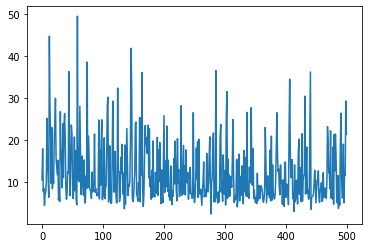

In [47]:
import matplotlib.pyplot as plt

plt.plot(np.array(loss_log))

In [48]:
print(out)

tensor([[[ 1.8310e-01, -4.2476e-01],
         [ 1.5914e-01,  1.9628e-03],
         [-4.6995e-02,  1.1458e-01],
         ...,
         [ 7.6170e-03,  4.1051e-02],
         [-2.7421e-01,  2.7821e-01],
         [-1.5481e-01,  1.0454e-01]],

        [[ 6.6041e-01,  6.9480e-01],
         [ 1.2126e-01, -6.8379e-01],
         [ 3.1913e-01, -9.9805e-01],
         ...,
         [-5.9067e-01, -6.2891e-01],
         [ 1.0239e+00, -1.4181e-01],
         [ 1.4057e+00, -2.4383e-01]],

        [[ 1.5732e+00,  8.4011e-01],
         [ 3.3699e-01, -1.1698e+00],
         [ 2.1163e-01, -1.4536e+00],
         ...,
         [-1.5293e+00, -1.0544e+00],
         [ 1.8858e+00, -4.0741e-01],
         [ 2.5703e+00, -1.0408e+00]],

        ...,

        [[-1.0208e+02,  2.4389e+02],
         [-4.5408e+01, -5.4400e+00],
         [ 2.4738e+02,  4.8769e+01],
         ...,
         [-1.8133e+02,  2.2193e+02],
         [-2.2441e+02, -1.1226e+02],
         [ 1.4660e+02, -1.0796e+02]],

        [[-1.0172e+02,  2.4430e+02

In [49]:
import datetime

now = datetime.datetime.now()

bestParams = extractParams(model)

np.savez(savedir+'bestParams_' + now.strftime('%Y%m%d_%H%M%S'),
        bestParams=bestParams,
        optimizer=optimizer,
        loss_log=loss_log,
        lossfunc=lossfunc)